In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()


Mounted at /content/gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from fastai.vision.all import *
from fastai.data.all import *
from fastai.imports import *
from fastai.vision.core import *
from fastai import metrics
torch.cuda.get_device_properties(0).total_memory

15812263936

In [ ]:
path=Path("/content/drive/My Drive/DATA_HAR")

# **DATA BLOCK AND LOADER**

In [ ]:
def get_tuple_files(path):
    files = get_image_files(path)
    files = files.filter(lambda f: f.name.endswith('vhr.tif'),negate=False)
    return files


In [ ]:
def label_func(x):
      return str(x.parents[0]/x.stem[0:23])+"_mask_build.tif";

In [ ]:
 seg = DataBlock(blocks=(ImageBlock(), MaskBlock( codes =['n','y'])),
                
    item_tfms=[Resize(512,method='squish',resamples=(Image.BICUBIC,Image.BICUBIC)),ToTensor],
    batch_tfms=[IntToFloatTensor(),Normalize.from_stats(*imagenet_stats)],
    
    get_items=get_tuple_files,            
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=label_func)
    

In [ ]:
seg.summary(path)

Setting-up type transforms pipelines
Found 3712 items
2 datasets of sizes 2970,742
Setting up Pipeline: PILBase.create
Setting up Pipeline: label_func -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/drive/My Drive/DATA_HAR/E244100N3304900UTM15R_2_vhr.tif
    applying PILBase.create gives
      PILImage mode=RGB size=512x512
  Pipeline: label_func -> PILBase.create
    starting from
      /content/drive/My Drive/DATA_HAR/E244100N3304900UTM15R_2_vhr.tif
    applying label_func gives
      /content/drive/My Drive/DATA_HAR/E244100N3304900UTM15R_2_mask_build.tif
    applying PILBase.create gives
      PILMask mode=L size=512x512

Final sample: (PILImage mode=RGB size=512x512, PILMask mode=L size=512x512)


Setting up after_item: Pipeline: AddMaskCodes -> Resize -- {'size': (512, 512), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (3, 3), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline:

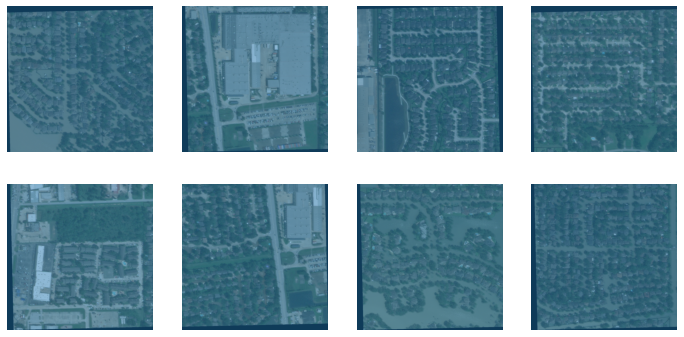

In [ ]:
dls = seg.dataloaders(path,bs=8)
dls.show_batch()

In [ ]:
b = dls.one_batch()

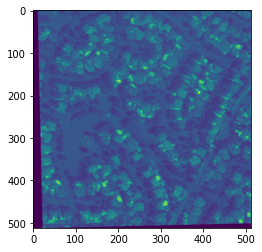

In [ ]:
plt.imshow(b[0][0][2].cpu().numpy())

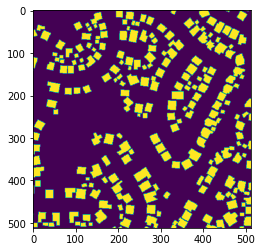

In [ ]:
plt.imshow(b[1][0].cpu().numpy())

# **MODEL SUMMARY**

In [ ]:
learn= unet_learner(dls,resnet34, metrics=[Dice()])

learn.summary()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


DynamicUnet (Input shape: ['8 x 3 x 512 x 512'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               8 x 64 x 256 x 256   9,408      False     
________________________________________________________________
BatchNorm2d          8 x 64 x 256 x 256   128        True      
________________________________________________________________
ReLU                 8 x 64 x 256 x 256   0          False     
________________________________________________________________
MaxPool2d            8 x 64 x 128 x 128   0          False     
________________________________________________________________
Conv2d               8 x 64 x 128 x 128   36,864     False     
________________________________________________________________
BatchNorm2d          8 x 64 x 128 x 128   128        True      
________________________________________________________________
ReLU                 8 x 64 x 128 x 128   0          False     
_________________________________________________

In [ ]:
learn.lr_find()

KeyboardInterrupt: ignored

In [ ]:
learn.fine_tune(6,base_lr=2e-3)

epoch,train_loss,valid_loss,dice,time
0,0.385649,0.373414,0.119449,09:43


epoch,train_loss,valid_loss,dice,time
0,0.279501,0.261079,0.635431,09:56
1,0.196526,0.187512,0.769557,09:54
2,0.159427,0.152478,0.814517,09:52
3,0.137015,0.132051,0.847349,09:53
4,0.120892,0.122844,0.856942,09:53
5,0.115424,0.121147,0.859523,09:54


In [ ]:
learn.save("patch-build")

Path('models/patch-build.pth')

In [ ]:
learn.export("patch-building.pkl")

# **TESTING**

In [ ]:
im=PILImage.create("/content/drive/My Drive/DATA_HAR/E249800N3305400UTM15R_1_vhr.tif")

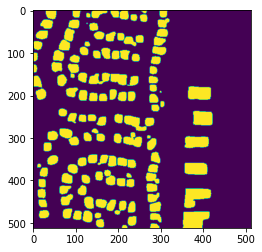

In [ ]:
plt.imshow(learn.predict(im)[0])

In [ ]:
learn.load("/content/drive/My Drive/patch-build")